In [94]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict

# Preprocessing

In [29]:
## DEFINE INPUT PARAMETERS
# defining velocity, density, and viscocity for fluid
u0 = 1 # lid velocity
rho0 = 1
nu0 = 0.01
N = 4400 # number of collocation data points [x,y]

In [118]:
def Uniform_with_Cylinder(u0, N_col=10000, N_circ=200, r=0.1):
    """
    Create collocation points inside a 1by1 box with a cylinder in the middle

    Args:
        u0 : Inlet velocity
        N_col : number of collocation points # note the acc number is slightly less as we are removing points in the cylinder
        N_circ : Number of points along cylinder boundary
        r : Cylinder radius 
    
    Returns: 
        Tensors of:
        X_col : Collocation points [x, y]
        BC_X : Boundary points [x, y]
        BC_Y : Boundary condition values [u, v]
    """

    # setting up domain size
    # NOTE these cylinder centre points are only for a 1 by 1
    xc, yc = 0.5, 0.5  # cylinder center

    # CREATING collocation points
    # set random points 
    xy = np.random.rand(N_col, 2)  

    # Distance from cylinder center
    dist = np.sqrt((xy[:, 0] - xc)**2 + (xy[:, 1] - yc)**2)

    # Keep only points outside the cylinder
    valid_col = dist > r
    xy_outside = xy[valid_col]

    X_col = torch.tensor(xy_outside, dtype=torch.float32)

    # CREATING Boundary condition locations
    # so for a 1 by 1 box Left (x=0), Right (x=1), Bottom (y=0), Top (y=1)

    # evenly distribute BC points along the sides
    N_BC = int(np.sqrt(N_col) // 2)
    y = np.linspace(0, 1, N_BC)
    x = np.linspace(0, 1, N_BC)

    # turn those points into x,y co-ords
    b_left   = np.column_stack([np.zeros_like(y), y])
    b_right  = np.column_stack([np.ones_like(y), y])
    b_bottom = np.column_stack([x, np.zeros_like(x)])
    b_top    = np.column_stack([x, np.ones_like(x)])

    # cylinder BCs
    theta = np.linspace(0, 2*np.pi, N_circ)
    cylinder_x = (r * np.cos(theta) + xc)
    cylinder_y = (r * np.sin(theta) + yc)
    cylinder_xy = np.column_stack([cylinder_x, cylinder_y])

    # Add all BC points
    BC_X_np = np.vstack([b_left, b_bottom, b_right, b_top, cylinder_xy])
    BC_X = torch.tensor(BC_X_np, dtype=torch.float32)

    # CREATING the BC_Y essentially 0s everywhere except inlet
    # tensor of zeros for all walls except inlet
    walls_Y = torch.zeros_like(torch.tensor(np.vstack([b_top, b_bottom, b_right]), dtype=torch.float32))

    # inlet velocity
    inlet = torch.zeros_like(torch.tensor(b_left, dtype=torch.float32))
    inlet[:, 0] = u0

    # Cylinder no slip so 0
    cylinder_uv = torch.zeros_like(torch.tensor(cylinder_xy, dtype=torch.float32))

    # Combine boundary velocities
    BC_Y = torch.cat([inlet, walls_Y,  cylinder_uv], dim=0)

    return X_col, BC_X, BC_Y

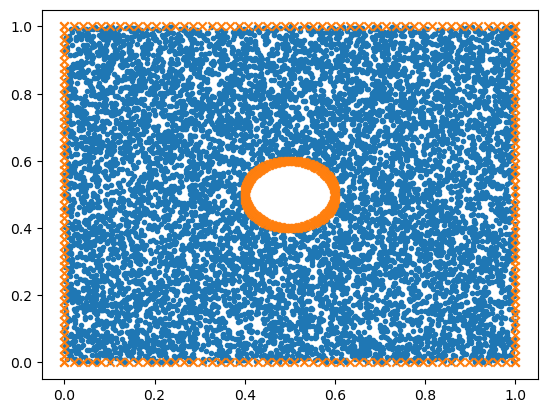

In [119]:
X_col, BC_X, BC_Y= Uniform_with_Cylinder(1)

plt.scatter(X_col[:,0].numpy(),X_col[:,1].numpy(),marker='.')
plt.scatter(BC_X[:,0].numpy(),BC_X[:,1].numpy(),marker='x')

In [97]:
## Compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True
    )[0]
def compute_gradients(model, xy):
    """
    Args:
        model : PyTorch neural network, with three models inside it (u,v and p) for input xy
        xy    : tensor of shape (N, 2), # when setting up model set requires_grad=True

    Returns:
        p_grads : (p, p_x, p_y) as a tuple
        u_grads : (u, u_x, u_y, u_xx, u_yy) as a tuple
        v_grads : (v, v_x, v_y, v_xx, v_yy) as a tuple
    """
    # create a clone so we dont change the original tensor
    # detatch the xy data from previous gradients so it can be evaluated in isolation
    xy = xy.clone().detach().requires_grad_(True)  
    x = xy[:, 0:1]
    y = xy[:, 1:2]

    # Make a fwd pass that goes through the combined mini models collecting all coefficients needed for derivatives
    u_v_p = model(torch.cat([x, y], dim=1))
    u = u_v_p[:,0:1]
    v = u_v_p[:,1:2]
    p = u_v_p[:,2:3]

    
    # First-order derivatives
    p_x = grad(p, x)
    p_y = grad(p, y)

    # Second-order derivatives
    u_x = grad(u, x)
    u_y = grad(u, y)
    v_x = grad(v, x)
    v_y = grad(v, y)

    # Third-order derivatives
    u_xx = grad(u_x, x)
    u_yy = grad(u_y, y)
    v_xx = grad(v_x, x)
    v_yy = grad(v_y, y)
    
    p_grads = (p, p_x, p_y)
    u_grads = (u, u_x, u_y, u_xx, u_yy)
    v_grads = (v, v_x, v_y, v_xx, v_yy)

    return p_grads, u_grads, v_grads

# Model Creation

In [99]:
## LOSS EQUATIONS
def navier_stokes_loss(model,X):
    """
    calculates steady navier stokes residuals at collocation points

    Args: 
        model : whatever model calls this function
        X : input collocation [x,y] coords as defined in models data creation

    Returns: 
        tensor of all collocation point residuals
    """
    p_grads, u_grads, v_grads = compute_gradients(model, X)
    _, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    #compute PDE residuals
    u_eqn = u*u_x + v*u_y + p_x/rho0 - nu0*(u_xx + u_yy)
    v_eqn = u*v_x + v*v_y + p_y/rho0 - nu0*(v_xx + v_yy)
    

    # combine into one tensor
    # [u_residual, v_residual, continuity]
    return torch.cat([u_eqn, v_eqn,(u_x+v_y)], dim=1)
    
def BC_loss(model,BC_X):
    """
    calculates u and v at boundary conditions

    Args: 
        model : whatever model calls this function
        BC_X : Input Boundary conditions [x,y] coords as defined in models data creation
        
    Returns: 
        tensor of u,v at all boundary condition coords
    """
    _, u_grads, v_grads = compute_gradients(model,BC_X)
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    return torch.cat([u, v], dim=1)

## Define sub models and combine into 1 model

In [100]:
## CREATING THE MINI MODEL FOR u,v AND p AND THEN COMBINE THEM INTO ONE MODEL

# sub model for u,v and p 
class submodel(nn.Module):
    def __init__(
            self,
            N_input,
            N_hidden_arr,
            N_output,
            activation = nn.Tanh
    ):
        super(submodel, self).__init__()  # Create network

        # Create input layer w/ activation function
        layers = [('Input', nn.Linear(N_input, N_hidden_arr[0]))]
        layers.append(('Input activation', activation()))

        # Create hidden layers
        for i in range(len(N_hidden_arr)-1):
            layers.append(
                ("Hidden %d" % (i+1), nn.Linear(N_hidden_arr[i], N_hidden_arr[i+1]))
            )
            layers.append(('Hidden activation %d' % (i+1), activation()))
        layers.append(('Output', nn.Linear(N_hidden_arr[-1], N_output)))
        layerdict = OrderedDict(layers)
        self.layers = nn.Sequential(layerdict)

    def forward(self, x):
        y = self.layers(x)
        return y


class Net(nn.Module):
    def __init__(self, N_input, N_hidden_arr, N_output, activation = nn.Tanh):
        
        super(Net, self).__init__()  # Create network
        # creates three models using submodel as the blueprint
        self.model_u = submodel(N_input, N_hidden_arr ,N_output, activation)
        self.model_v = submodel(N_input, N_hidden_arr, N_output, activation)
        self.model_p = submodel(N_input, N_hidden_arr, N_output, activation)


    # combine the outputs of all the models into a single output
    def forward(self, xy):
        out_u = self.model_u(xy)
        out_v = self.model_v(xy)
        out_p = self.model_p(xy)
        combined = torch.cat((out_u, out_v, out_p), dim=1)
        return combined


        

## Defining the model

In [102]:
## create neural network

class PINN:
    def __init__(self):
        ### Need to change this to check if gpu available as well
        device = torch.device("cpu")
        print("Using CPU")
        self.model = Net(
            N_input=2,
            N_hidden_arr=[32,16,16,32],
            N_output = 1
        ).to(device)
    
        # DATA CREATION 
        self.X, self.BC_X, self.BC_Y =  Uniform_with_Cylinder(u0)

        # copy and seperate tensors into format for loss calculations
        self.X = self.X.clone().detach().requires_grad_(True)
        self.BC_X = self.BC_X.clone().detach().requires_grad_(True)

        
        # OPTIMISERS
        self.optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1.0,
            max_iter = 75*10**3,
            max_eval = 75*10**3,
            history_size=50,
            tolerance_change=1e-7,
            tolerance_grad=1e-7,
            line_search_fn="strong_wolfe"
        )
        self.adam = torch.optim.Adam(self.model.parameters())

        
        self.loss_fn = nn.MSELoss()

        # Counter for printing loss
        self.iter =1
        
    # Loss
    def compute_loss(self):
        # Compute PDE residuals at collocation points
        residuals = navier_stokes_loss(self.model, self.X)
        ru, rv, conservation  = residuals[:, 0:1], residuals[:, 1:2], residuals[:, 2:3]

        # PDE loss (residuals against tensor of zeros)
        pde_loss = self.loss_fn(ru, torch.zeros_like(ru)) + self.loss_fn(rv, torch.zeros_like(rv))+self.loss_fn(conservation, torch.zeros_like(conservation))

        # BC loss
        bc_loss = BC_loss(self.model,self.BC_X)
        bc_loss = self.loss_fn(bc_loss,self.BC_Y)
        
        
        total_loss = pde_loss + bc_loss

        # print the loss
        if self.iter % 100 == 0:
            print(f"Iteration {self.iter:5}, Total Loss {total_loss:.9f}")
        self.iter+= 1
        
        return total_loss
    
    def train(self, adam_epochs=300, lbfgs_epochs=10):
        self.model.train()

        for epoch in range(adam_epochs):
            self.adam.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            self.adam.step()

            # extra printing of loss for when adam optimiser in use
            if epoch % 50 == 0:
                with torch.inference_mode():  
                    print(f"[Adam] Step {epoch:4}, Loss = {loss.item():.6e}")
        
        for epoch in range(lbfgs_epochs):
            def closure():
                self.optimiser.zero_grad()
                loss = self.compute_loss()
                loss.backward()
                return loss

            self.optimiser.step(closure)
            
    def eval(self):
        self.model.eval()

In [103]:
test = PINN()
print(test)

Using CPU


In [104]:
test.train()

[Adam] Step    0, Loss = 7.096709e-02
[Adam] Step   50, Loss = 4.366737e-02
Iteration   100, Total Loss 0.041505396
[Adam] Step  100, Loss = 4.147445e-02
[Adam] Step  150, Loss = 4.008773e-02
Iteration   200, Total Loss 0.039508745
[Adam] Step  200, Loss = 3.948596e-02
[Adam] Step  250, Loss = 3.927125e-02
Iteration   300, Total Loss 0.039090931
Iteration   400, Total Loss 0.038149878
Iteration   500, Total Loss 0.037623800
Iteration   600, Total Loss 0.037363272
Iteration   700, Total Loss 0.036932886
Iteration   800, Total Loss 0.036542296
Iteration   900, Total Loss 0.035936411
Iteration  1000, Total Loss 0.034976568
Iteration  1100, Total Loss 0.034640979
Iteration  1200, Total Loss 0.034392338
Iteration  1300, Total Loss 0.034239002
Iteration  1400, Total Loss 0.034145441
Iteration  1500, Total Loss 0.034046259
Iteration  1600, Total Loss 0.033975266
Iteration  1700, Total Loss 0.033885304
Iteration  1800, Total Loss 0.033776794
Iteration  1900, Total Loss 0.033616569
Iteration  2

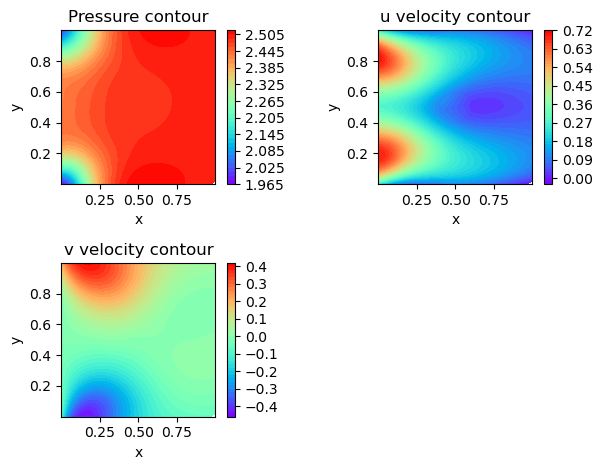

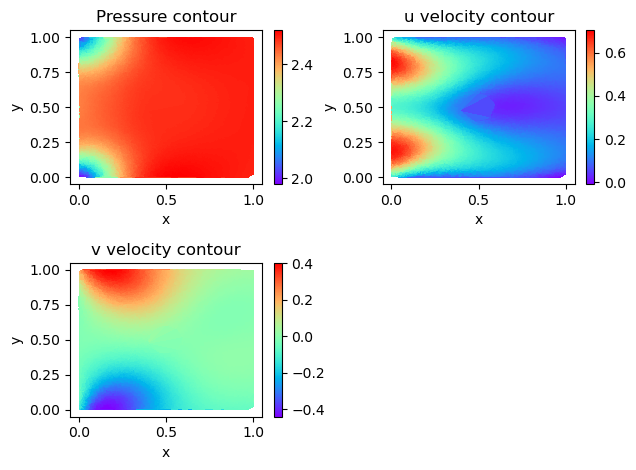

<Figure size 640x480 with 0 Axes>

In [113]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

X, BC_X, BC_Y = Uniform_with_Cylinder(u0)
    
X = X.clone().detach().requires_grad_(True)      


# forward pass of the model !!! fwd pass outside eval/inference is okay as long as you dont .backward()
# we have to call .model() because our model is nested inside class PINN
y_preds = test.model(X)
u = y_preds[:, 0:1]   # u velocity
v = y_preds[:, 1:2]
p = y_preds[:, 2:3]     #pressure


# convert to array for postprocessing
p_np   = p.detach().numpy()
u_np   = u.detach().numpy()
v_np   = v.detach().numpy()
x_np   = X[:, 0:1].detach().numpy()
y_np   = X[:, 1:2].detach().numpy()


def tricontour(gs, x, y, z, title):
      """
    this is an explanation for tripcontour() and tripplot() which are two different methods for plotting contour type plots

    Args:
        grid: plot position in subplot
        x: x-array (x coords)
        y: y-array  (y coords)
        z: z-array (engineering value at [x,y])
        title: title 
    """
    plt.subplot(gs)
    tcf = plt.tricontourf(x, y, z, levels=50, cmap='rainbow')
    plt.colorbar(tcf)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    

# note we have to squeeze the arrays as they are in column vector format(ML format)
gs = GridSpec(2,2)
tricontour(gs[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tricontour(gs[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tricontour(gs[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()


def tripplot(gs, x, y, z, title):
    plt.subplot(gs)
    plt.tripcolor(x, y, z, cmap='rainbow')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

gs2 = GridSpec(2,2)
tripplot(gs2[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tripplot(gs2[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tripplot(gs[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()
